# Procesamiento Digital de Audio
## Caleb Rascón
### Separación de Fuentes en Línea

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy.fft import fft, ifft
from matplotlib import pyplot as plt
from delay_f import delay_f
from trianglewave import trianglewave


In [2]:

# Parameters
doa1 = 20 * np.pi / 180  # direction of arrival of first signal
doa2 = -40 * np.pi / 180  # direction of arrival of second signal
doa_steer = doa1  # direction to steer the beamformer (original: doa1)
phase_diff_threshold = 0.01 * np.pi / 180  # mask threshold in radians (original: 0.01 degrees)
d = 4  # distance between microphones in meters (original: 4)
M = 2  # number of microphones (only works with 2)
N = 200  # signal size in samples


In [3]:

# Simulating signals
t = np.arange(1, N + 1) / N  # time vector (1 second)
c = 343  # speed of sound
fs = N  # sampling frequency same as signal size (1 second)
wp = np.concatenate(([0], np.arange(1, N//2 + 1), np.arange(N//2-1, 0, -1))) / N * fs

# Original signals
s1 = np.cos(2 * np.pi * 2 * t)
s2 = trianglewave(10, N) * 0.5


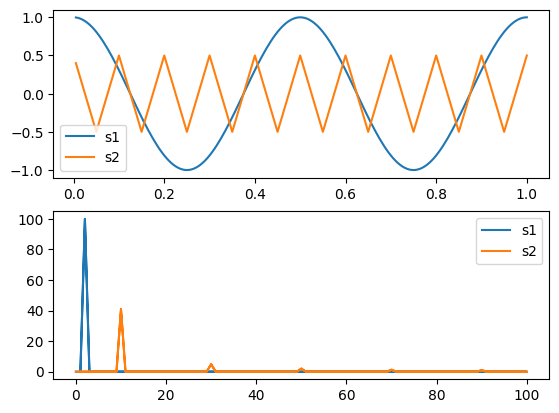

In [8]:
plt.subplot(2, 1, 1)
plt.plot(t, s1, label='s1')
plt.plot(t, s2, label='s2')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(wp, np.abs(np.fft.fft(s1)), label='s1')
plt.plot(wp, np.abs(np.fft.fft(s2)), label='s2')
plt.legend()
plt.show()


/home/qweryedu/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


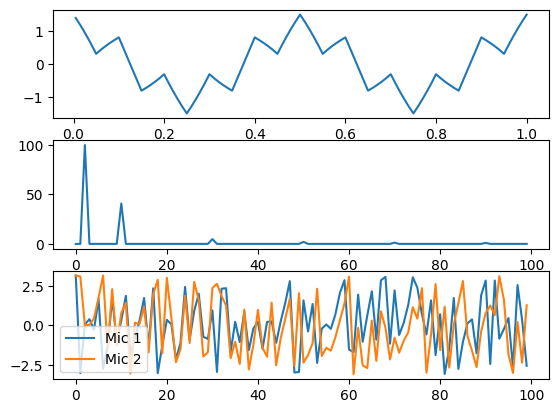

In [5]:

# Microphones (input signals)
X = np.zeros((M, N), dtype=complex)
X[0, :] = s1 + s2
X[1, :] = delay_f(s1, (d / c) * np.sin(doa1), N) + delay_f(s2, (d / c) * np.sin(doa2), N)

plt.subplot(3, 1, 1)
plt.plot(t, X[0, :])
plt.subplot(3, 1, 2)
plt.plot(wp[:N//2], np.abs(np.fft.fft(X[0, :])[:N//2]))
plt.subplot(3, 1, 3)
plt.plot(wp[:N//2], np.angle(np.fft.fft(X[0, :])[:N//2]), label='Mic 1')
plt.plot(wp[:N//2], np.angle(np.fft.fft(X[1, :])[:N//2]), label='Mic 2')
plt.legend()
plt.show()


In [6]:

# Doing frequency masking
# Calculating the steering vector
w_c = np.zeros((M, N), dtype=complex)
w = np.concatenate(([0], np.arange(1, N//2 + 1), np.arange(-N//2 + 1, 0))) / N * fs
w_c[0, :] = np.ones(N)
for f in range(N):
    w_c[1, f] = np.exp(-1j * (2 * np.pi * w[f] * d / c) * np.sin(doa_steer))  # steering vector for this frequency

# FFT
for m in range(M):
    X[m, :] = np.fft.fft(X[m, :])

o_f = np.zeros(N, dtype=complex)
freq_mask = np.zeros(N)

o_f[0] = X[0, 0]
for f in range(1, N):
    # Aligning the other microphone given the steering vector
    align_m2 = w_c[1, f].conj() * X[1, f]
    
    this_m1_phase = np.angle(X[0, f])
    this_m2_phase = np.angle(align_m2)
    
    # Calculating phase difference
    phase_diff = this_m1_phase - this_m2_phase
    
    if np.abs(phase_diff) < phase_diff_threshold:
        freq_mask[f] = 1
    else:
        freq_mask[f] = 0
    
    o_f[f] = freq_mask[f] * X[0, f]

o = np.real(np.fft.ifft(o_f))


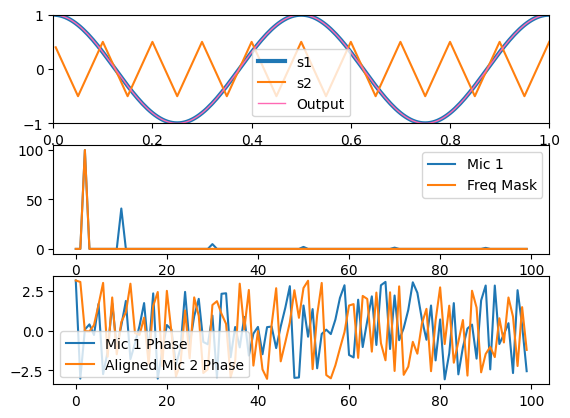

In [10]:
plt.subplot(3, 1, 1)
plt.plot(t, s1, label='s1', linewidth=3)
plt.plot(t, s2, label='s2')
plt.plot(t, o, label='Output', linewidth=1, color='hotpink')
plt.axis([0, 1, -1, 1])
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(wp[:N//2], np.abs(X[0, :])[:N//2], label='Mic 1')
plt.plot(wp[:N//2], freq_mask[:N//2] * 100, label='Freq Mask')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(wp[:N//2], np.angle(X[0, :])[:N//2], label='Mic 1 Phase')
plt.plot(wp[:N//2], np.angle(w_c[1, :] * X[1, :])[:N//2], label='Aligned Mic 2 Phase')
plt.legend()

plt.show()
